# FAIKR module 3 project

#Lorenzo Venieri
#Luca Zucchini

## Introduction

Diabetes is a serious disease affecting millions of people across the entire world. Thus, correct and timely prediction of this disease is very important due to the complications it can have in the case of other life-threatening diseases.

Objective of this project is to apply the studied notions about Bayesian Networks to implement a probabilistic model on a dataset built from patients with diabetes.

## Dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.  
The Pima (or Akimel O'odham, also spelled Akimel Oʼotham, "River People," formerly known as Pima) are a group of Native Americans living in an area consisting of what is now central and southern Arizona, as well as northwestern Mexico in the states of Sonora and Chihuahua.
The diversion of the water and the introduction of non-native diet is said to have been the leading contributing factor in the high rate of diabetes among the Akimel Oʼodham tribe. They have the highest prevalence of type 2 diabetes in the world, much more than is observed in other U.S. populations.    
The general increased diabetes prevalence among Native Americans has been hypothesized as the result of the interaction of genetic predisposition (the thrifty phenotype or thrifty genotype), as suggested by anthropologist Robert Ferrell in 1984[13] and a sudden shift in diet during the last century from traditional agricultural crops to processed foods, together with a decline in physical activity.  
Between U.S. Pima indians, 34.2% of men and 40.8% of women suffer from diabetes as reported in https://doi.org/10.2337/dc06-0138.

From the data set in the (.csv) file we can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

We have 9 different attributes:
1. Pregnancies: number of pregnancies
2. Glucose: plasma glucose concentrarion 
3. BloodPressure: diastolic blood pressure mm/Hg
4. SkinThickness: triceps skin fold thickness (mm)
5. Insulin: insulin in U/mL
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. Diabetes Pedigree Function: scores likelihood of diabetes based on family history
8. Age: age of the person (years)
9. Outcome: patient has diabetes (0 = No, 1 = Yes)

The dataset contains info about 768 patients.

In [36]:
%pip install pgmpy


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_raw = pd.read_csv("data/diabetes.csv")
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Exploratory Data Analysis

In [38]:
#Diabetes distribution in the dataset

df_raw['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In the dataset there are 268 patients with diabetes and 500 without. The Outcome column is imbalanced: only about 35% of the entries have diabetes. We will check, after the cleaning of the dataset if this will still be the case.

/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_27749/2705674253.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_27749/2705674253.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

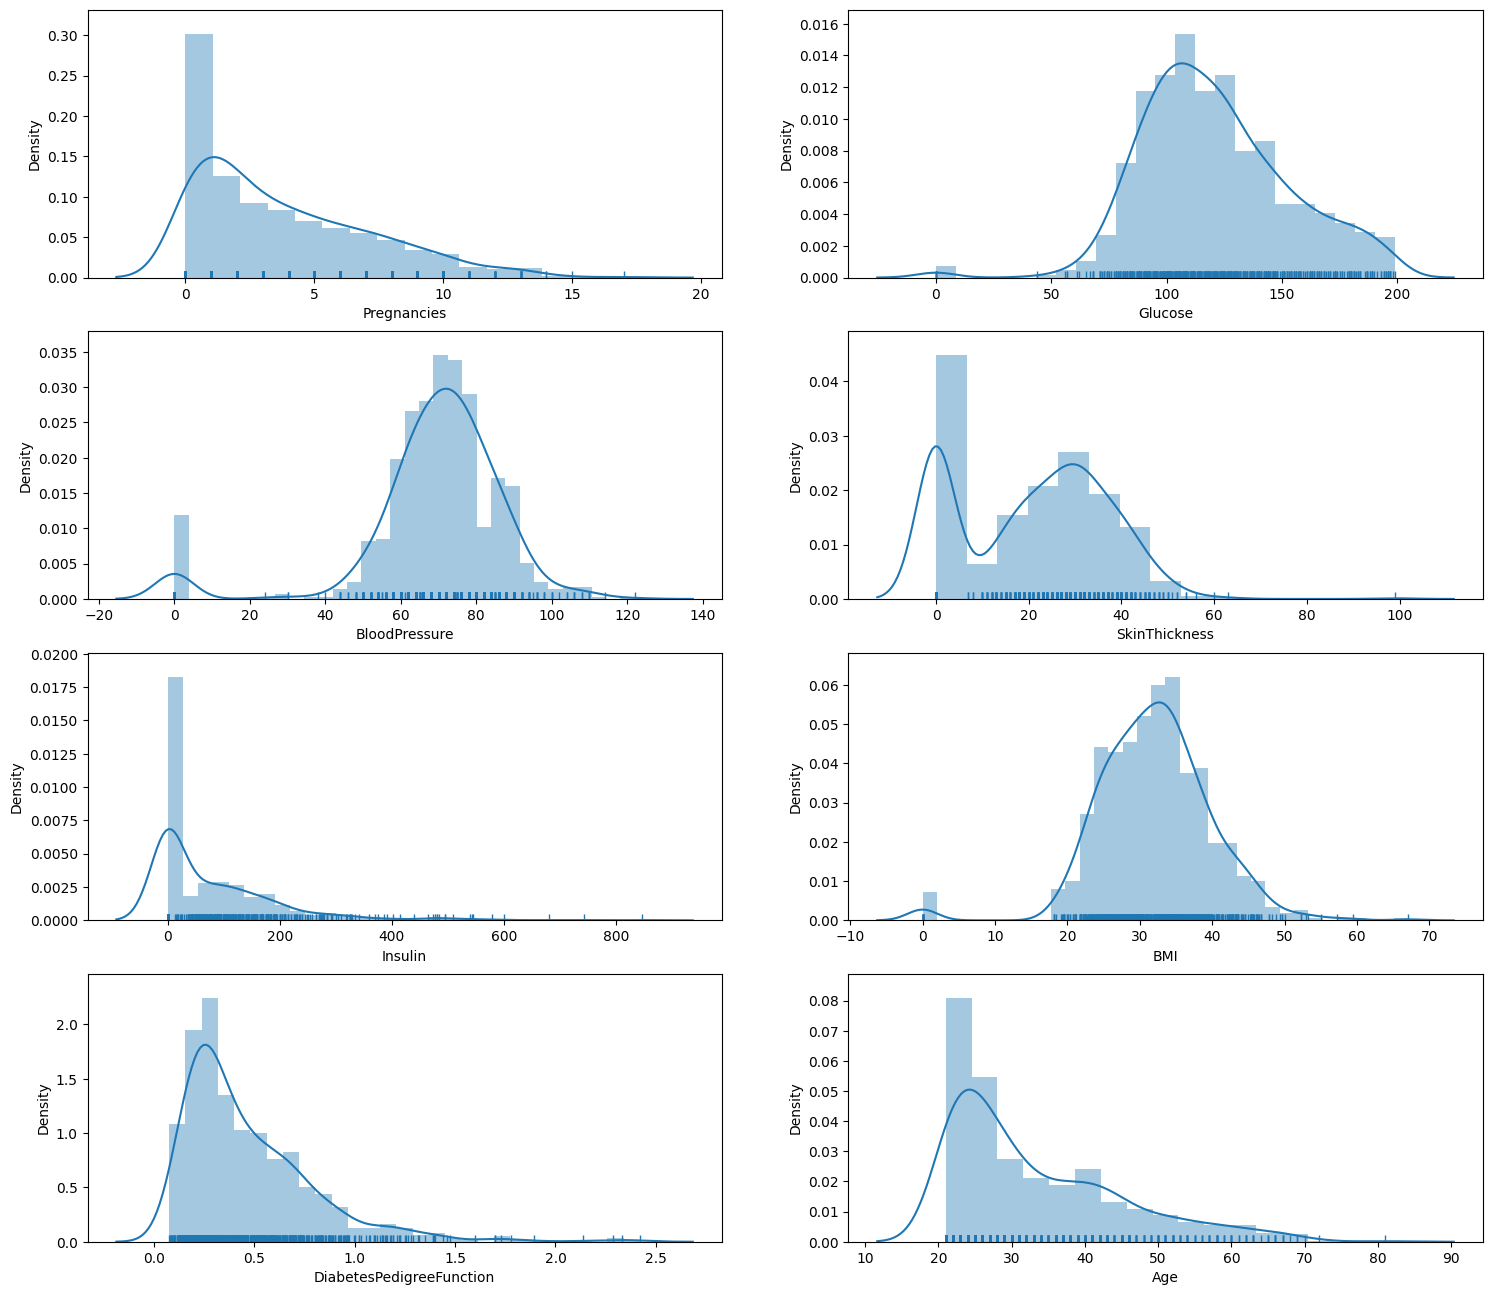

In [39]:
#Visualization of the other 8 (continuous) features

fig, axs = plt.subplots(4, 2, figsize=(18,16))
axs = axs.flatten()
sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
sns.distplot(df_raw['Glucose'],rug=True,ax=axs[1])
sns.distplot(df_raw['BloodPressure'],rug=True,ax=axs[2])
sns.distplot(df_raw['SkinThickness'],rug=True,ax=axs[3])
sns.distplot(df_raw['Insulin'],rug=True,ax=axs[4])
sns.distplot(df_raw['BMI'],rug=True,ax=axs[5])
sns.distplot(df_raw['DiabetesPedigreeFunction'],rug=True,ax=axs[6])
sns.distplot(df_raw['Age'],rug=True,ax=axs[7])
plt.show()

The dataset has the column representing the presence of diabetes in the patient named as "Outcome" and in the description of the dataset there is no indication whether it takes in consideration type 1 Diabetes, type 2 Diabetes or both of them. To resolve this ambiguity we check if there are positives outcomes in rows with very low values of "Insulin": clear indication of type 1 Diabetes presence


In [40]:
count = 0
for i in range(df_raw.shape[0]):
    if df_raw["Insulin"][i] < 1 and df_raw["Outcome"][i] == 1 :
        count += 1
print("in the dataset there are ",count,"patients with type 1 diabetes")

in the dataset there are  138 patients with type 1 diabetes


### Data cleaning

In the dataset there are many null values that we have to handle. We decided to remove them instead of using statistical methods to predict the missing values, since we have few data and we want them to be as much predictive as possible. By the way, we have to consider that null values of Insulin are interesting as stated before.

In [41]:
for item in df_raw.columns :
    if item != "Outcome":
        print("In the column", item,"there are",(df_raw[item].values == 0).sum(),"null values")

In the column Pregnancies there are 111 null values
In the column Glucose there are 5 null values
In the column BloodPressure there are 35 null values
In the column SkinThickness there are 227 null values
In the column Insulin there are 374 null values
In the column BMI there are 11 null values
In the column DiabetesPedigreeFunction there are 0 null values
In the column Age there are 0 null values


We proceed with the removal of rows that have a null value in the columns: 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'.  
Previous analysis showed that DiabetesPedigreeFunction column and Age column don't contain any null values.

In [42]:
df_clean = df_raw.copy(deep=True)

In [43]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness','BMI'] 
#A null value in these columns is surely an error since it's impossible to have value zero for these fetures
for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 :
            drop_list.append(i)
    print("Column",item,"has been cleaned")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)
    

Column Glucose has been cleaned
Column BloodPressure has been cleaned
Column SkinThickness has been cleaned
Column BMI has been cleaned


With regard to the Insulin column we consider the fact that a null value of insulin in the blood is a sure sign of the presence of type 1 Diabetes, so we proceed with removing all the rows that have a null value of both Insuline and Outcome, since it's impossible to have no insulin without having diabetes.

In [44]:
for i in range(len(df_clean["Insulin"])):
    if df_clean["Insulin"][i] == 0 and df_clean["Outcome"][i] == 0:
        df_clean.drop(labels= i, axis= 0, inplace= True)
print("Column 'Insulin' has been cleaned")
df_clean.reset_index(drop=True, inplace=True)

Column 'Insulin' has been cleaned


We need to distinguish between type 1 and type 2 diabetes to better encode relationships between risk factors and effects of diabetes into the network. To do so, we build two columns from our Outcome column: Diabetes_1 and Diabetes_2, respectively for patients with very low levels of insulin and positive Outcome, and for patients with diabetes but not low levels of insulin.

In [45]:
df_clean["Diabetes_1"] = np.zeros(df_clean.shape[0])

for i in range(df_clean.shape[0]):
    if df_clean["Insulin"][i] <= 5 and df_clean["Outcome"][i] == 1:
        df_clean["Outcome"][i] = 0
        df_clean["Diabetes_1"][i] = 1

df_clean['Diabetes_1'] = df_clean['Diabetes_1'].apply(np.int64)
df_clean.rename(columns={"Outcome": "Diabetes_2"},inplace=True)

/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_27749/4281590103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Outcome"][i] = 0
/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_27749/4281590103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Diabetes_1"][i] = 1


In [46]:
df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes_2,Diabetes_1
0,6,148,72,35,0,33.6,0.627,50,0,1
1,1,89,66,23,94,28.1,0.167,21,0,0
2,0,137,40,35,168,43.1,2.288,33,1,0
3,3,78,50,32,88,31.0,0.248,26,1,0
4,2,197,70,45,543,30.5,0.158,53,1,0


We check now if the dataset is balanced with respect to the Diabetes columns

In [49]:
num_diab_1 = (df_clean["Diabetes_1"] == 1).sum()
num_diab_2 = (df_clean["Diabetes_2"] == 1).sum()
num_diab = num_diab_1 + num_diab_2

print('Number of patients with type 1 diabetes: ', num_diab_1)
print('Number of patients with type 2 diabetes: ', num_diab_2)
print('Total number of patients with diabetes: ', num_diab)
print('Number of patients without diabetes: ', df_clean.shape[0] - num_diab)

Number of patients with type 1 diabetes:  47
Number of patients with type 2 diabetes:  130
Total number of patients with diabetes:  177
Number of patients without diabetes:  262


The number of patients that suffer from diabetes is about 40% of the total population sample analyzed. This respects the data we have available regarding the incidence of diabetes in women belonging to the Pima tribe in the United States.  
For this reason we don't need to balance the dataset: it already represents the incidence of diabetes in the population under analysis.

### Binnerization
Now we need to modify the values of columns from continuous to discrete values. This transition is necessary in order to work with a bayesian network.
The binnarization was made trying to group values ​​into ranges of interest, rather than splitting them into 'n' number of bins.  

In [51]:
df_bin = df_clean.copy(deep=True)

In [52]:
#configuration dictionary for binnarization

conf = {"Pregnancies" :{
            "bins" : [-1,3,6,11,18],
            "labels": ["0-3","3-6","6-11","11+"]},

        "Glucose" :{
            "bins" : [70,100,140,np.max(df_clean["Glucose"])],
            "labels" : ["70-100","100-140","140-200"]},

        "BloodPressure" :{
            "bins" : [29,60,80,85,90,100,110],
            "labels" : ["30-60","60-80","80-85","85-90","90-100","100-110"]},

        "SkinThickness" :{
            "bins" : [6,15,30,40,np.max(df_clean["SkinThickness"])],
            "labels" : ["7-15","15-30","30-40","40+"]},

        "Insulin" : {
            "bins" : [-1,5,25,50,120,150,np.max(df_clean["Insulin"])],
            "labels" : ["0-5","5-25","25-50","50-120","120-150","150+"]},
            
        "BMI" :{
            "bins" : [19,25,30,np.max(df_clean["BMI"])],
            "labels" : ["19-25","25-30","30+"]},

        "DiabetesPedigreeFunction" :{
            "bins" : [-1,0.2,0.3,0.5,0.7,0.9,np.max(df_clean["DiabetesPedigreeFunction"])],
            "labels" : ["0-0.2","0.2-0.3","0.3-0.5","0.5-0.7","0.7-0.9","0.9+"]},
            
        "Age" :{
            "bins" : [20,30,40,50,60,np.max(df_clean["Age"])],
            "labels" : ["20-30","30-40","40-50","50-60","60+"]}
        }       


In [53]:
for item in conf.keys():
    df_bin[item] = pd.cut(x=df_clean[item], bins=conf[item]["bins"],
                        labels=conf[item]["labels"])

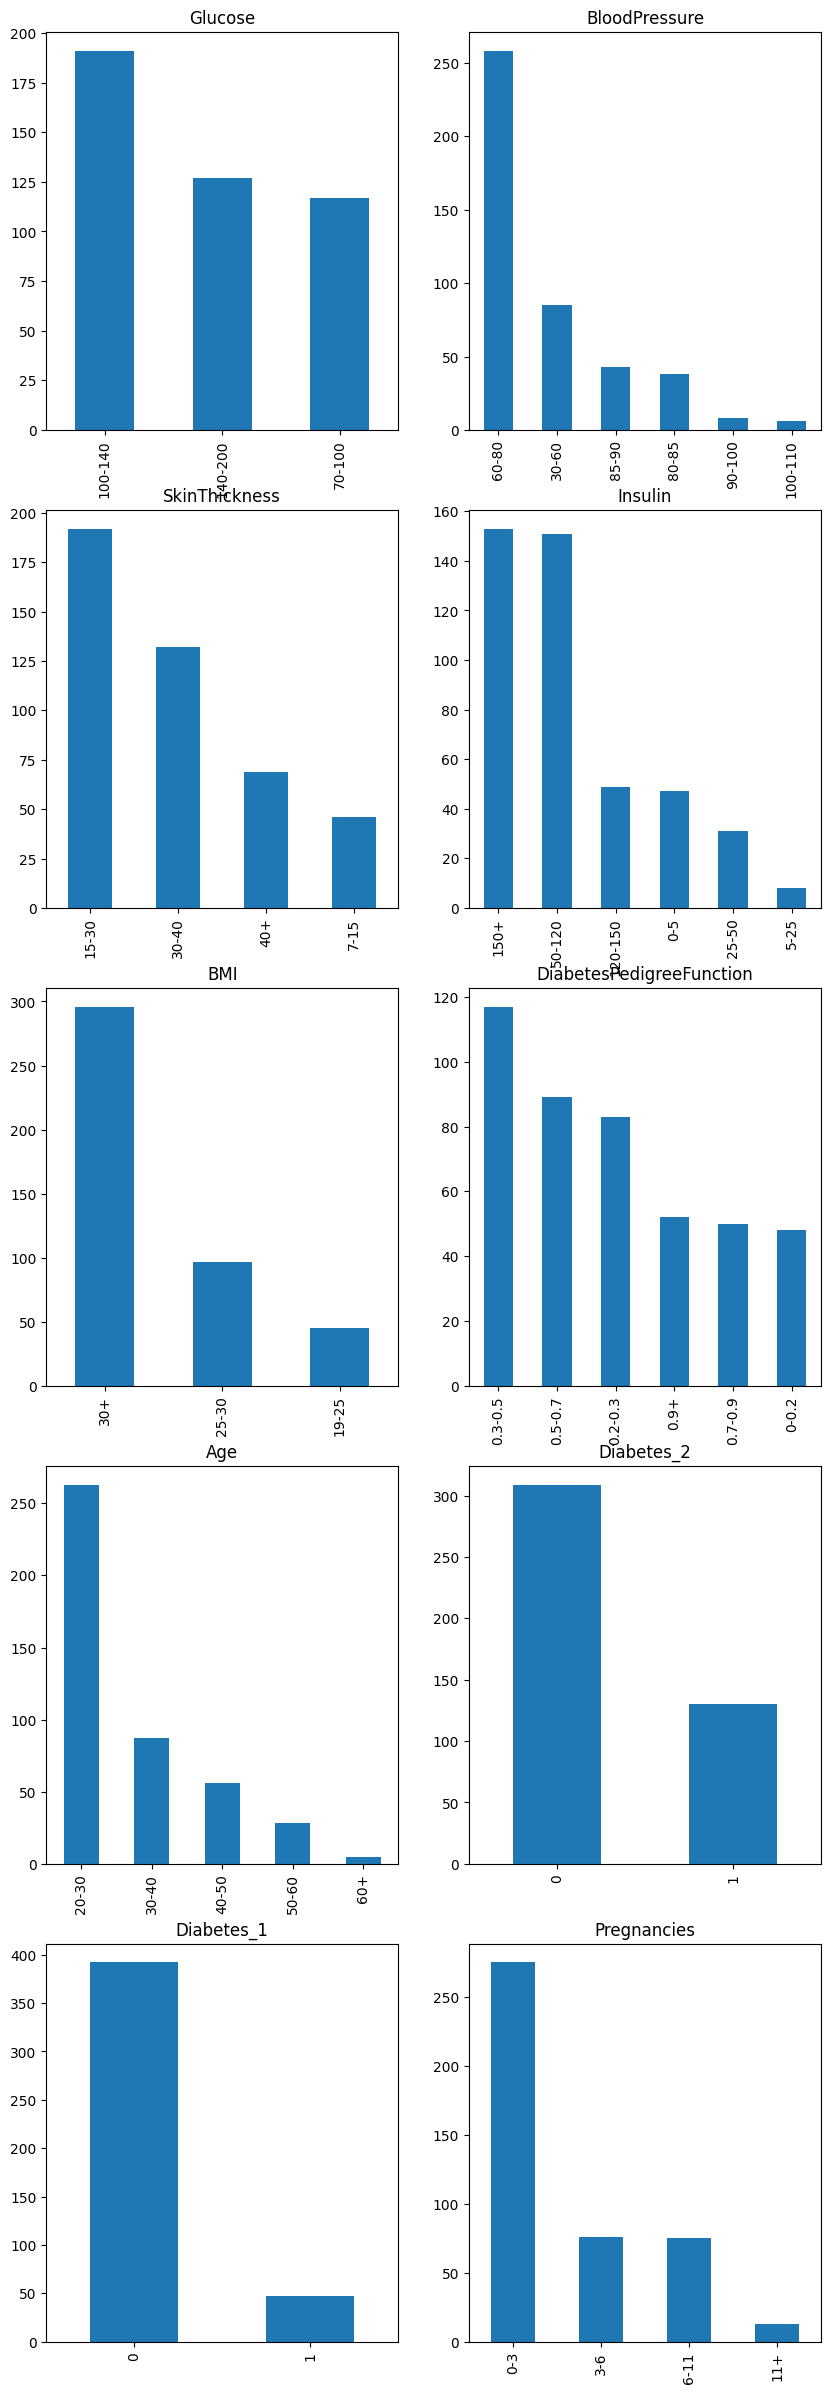

In [56]:
#Visualization of the binerized features distributions

fig, axs = plt.subplots(5, 2, figsize=(10,30))
axs = axs.flatten()
for n,column_name in enumerate(df_bin.columns):
    df_bin[column_name].value_counts().plot(kind='bar', title = column_name, ax = axs[n-1])


Now that bins have been correctly created, we move to designing the network

# Network


In this chapter we will build the network by analyzing correlations between the columns and scientific papers related to the topic. We will then explore a variety of methods related to the analysis of Bayesian Networks.

Analyzing the correlations between columns of the dataframe can help us reasoning about the causal relationships between them. 

<AxesSubplot:>

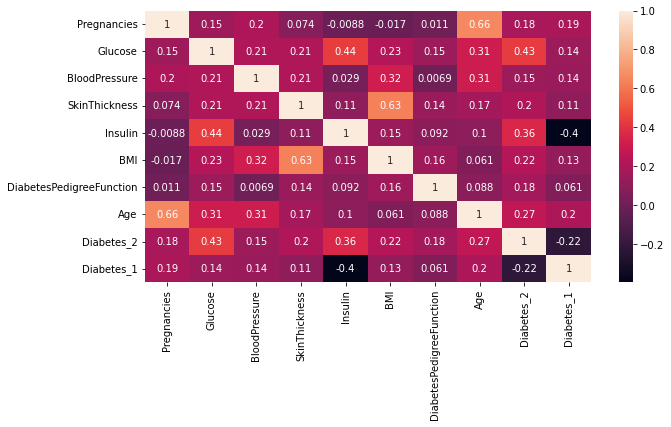

In [17]:
corr = df_clean.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)

#########c'è outcome

Age-pregnancies  
Outcome-glucose  
insulin-glucose  
insulin-skinthickness  
bmi-skinthickness    
Pregnancies - outcome: Gestational Diabetes  
This is a type of diabetes that is first seen in a pregnant woman who did not have diabetes before she was pregnant. Often gestational diabetes can be controlled through eating a healthy diet and exercising regularly. Sometimes a woman with gestational diabetes must also take insulin. Every year, 2% to 10% of pregnancies in the United States are affected by gestational diabetes.
For most women with gestational diabetes, the diabetes goes away soon after delivery. When it does not go away, the diabetes is called type 2 diabetes. Even if the diabetes does go away after the baby is born, half of all women who had gestational diabetes develop type 2 diabetes later.

### Showing the network

We show a graphical preliminary overview of the network using the visual library daft of pgmpy.  
The acronyms related to dataset attributes are the followings:

...


In [ ]:
%pip install daft

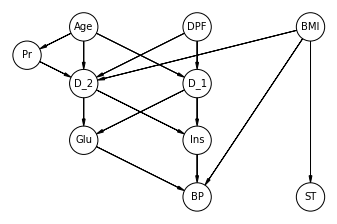

In [18]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM()

pgm.add_node(daft.Node('Age', "Age", 2, 4))
pgm.add_node(daft.Node('DPF', "DPF", 4, 4))
pgm.add_node(daft.Node('BMI', "BMI", 6, 4))

pgm.add_node(daft.Node('Pr', "Pr", 1, 3.5))

pgm.add_node(daft.Node('Diab_2', "D_2", 2, 3))
pgm.add_node(daft.Node('Diab_1', "D_1", 4, 3))

pgm.add_node(daft.Node('Glu', "Glu", 2, 2))
pgm.add_node(daft.Node('Ins', "Ins", 4, 2))

pgm.add_node(daft.Node('BP', "BP", 4, 1))
pgm.add_node(daft.Node('ST', "ST", 6, 1))

pgm.add_edge('Age', 'Pr')
pgm.add_edge('Pr', 'Diab_2')
pgm.add_edge('DPF', 'Diab_2')
pgm.add_edge('DPF', 'Diab_1')
pgm.add_edge('Age', 'Diab_2')
pgm.add_edge('Age', 'Diab_1')
pgm.add_edge('BMI','Diab_2')
pgm.add_edge('BMI','ST')
pgm.add_edge('BMI', 'BP')
pgm.add_edge('Diab_2', 'Glu')
pgm.add_edge('Diab_2', 'Ins')
pgm.add_edge('Diab_1', 'Glu')
pgm.add_edge('Diab_1', 'Ins')
pgm.add_edge('Glu', 'BP')
pgm.add_edge('Ins', 'BP')

pgm.render()
plt.show()

Examples of connections between nodes (e.g. direct cause, causal trail) refering to this specific Network are here shown:

#Direct cause

#Causal trail

#Common effect

## Creating the network

Connections between nodes have been implemented from scratch refering to a variety of scientific medical sources. Being the causal links, in the medical field particularly challenging to model, (i.e. often a huge variety of attributes are interlaced, causing directly or indirectly effects on each others) in this work only links that have been considered particularly relevant were defined.

Some of the connections are here explained and referenced:


In [19]:
import pgmpy
from pgmpy.models import BayesianNetwork

model = BayesianNetwork(
    [('Age','Pregnancies'),('Pregnancies', 'Diabetes_2'),('DiabetesPedigreeFunction', 'Diabetes_1'),('DiabetesPedigreeFunction', 'Diabetes_2'),
    ('Age', 'Diabetes_1'), ('Age', 'Diabetes_2'),('BMI','Diabetes_2'), ('BMI','SkinThickness'),('BMI', 'BloodPressure'),
    ('Diabetes_1', 'Glucose'),('Diabetes_1', 'Insulin'), ('Diabetes_2', 'Glucose'),('Diabetes_2', 'Insulin'),
    ('Glucose', 'BloodPressure'),('Insulin','BloodPressure')])

c:\Users\Luca\.virtualenvs\ML4downsyndrome-D1DocbTt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library in order to see in practice all the concepts addressed during the course.

In [ ]:
# Showing all the nodes of the model
model.nodes()

In [ ]:
# Showing all the edges of the model
model.edges()

In [ ]:
# Local independencies of a single node
model.local_independencies("Diabetes_1")

In [ ]:
model.local_independencies("SkinThickness")

In [46]:
######################### sarebbe bello che il primo fosse vero e poi falso?

# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any x ∈ X and y ∈ Y given Z

print(model.is_dconnected("BloodPressure", "SkinThickness"))
print(model.is_dconnected("BloodPressure", "SkinThickness",observed=["BMI"] ))

True
False


In [20]:
# Function is_irrelevant recalls the definition of irrelevance given during the course 

def is_irrelevant(node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("Node", node1, "is not irrelevant with resepect to", node2, "given the evidence", evidence)
  else:
    print("Node", node1, "is irrelevant with resepect to", node2, "given the evidence", evidence)

is_irrelevant("Glucose", "Insuline", "Diabetes_1")

Node Glucose is irrelevant with resepect to Insuline given the evidence Diabetes_1


In [21]:
# Checking active trails from blood pressure given the evidence diabetes
model.active_trail_nodes('BloodPressure', observed='Diabetes_1')

{'BloodPressure': {'Age',
  'BMI',
  'BloodPressure',
  'DiabetesPedigreeFunction',
  'Diabetes_2',
  'Glucose',
  'Insulin',
  'Pregnancies',
  'SkinThickness'}}

In [ ]:
# Checking the markov blanket of the node BloodPressure
model.get_markov_blanket("BloodPressure")

### Parameter learning

#####riscrivere un po

Learning Bayesian networks from data, knowing the structure of the network, boils down to parameter estimation. In pgmpy a variety of estimators is available, going from IVestimator to SEMestimator, but the main choice for this problem fell on two of them: Maximum Likelihood and Bayesian Estimator.

MLE, which depends solely on the outcomes of observed data, could be a reasonable simple starting point, however, it is notorious for becoming easily biased when the data is minimal. Moreover, in situations where observed data is sparse, Bayesian estimation’s incorporation of prior knowledge can help in attaining a more accurate model. 

On the other hand, unreliable priors can lead to a slippery slope of highly biased models that require large amounts of seen data to remedy; so priors need to be well defined and contain relevant insight to the problem in order to avoid that. 

Taken into consideration pros and cons of both approaches, given the minimal dataset used for this work the Bayesian Estimator is choosen.

Pgmpy also offer a variety of possible priors, among them a possible choice is Bayesian Dirichlet equivalent uniform prior (BDeu), choosen with its default settings (i.e. equivalent_sample_size equal to 5).

In the following cell the parameter estimation process takes place and the learned CPTs are shown.

In [22]:
from pgmpy.estimators import BayesianEstimator

df = df_bin

In [ ]:
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

In [ ]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()

In [ ]:
#Cardinality of all model nodes
model.get_cardinality()

## Inferences

Pgmpy allows to develop both exact and approximate inference on the Bayesian Network, in particular in this section both are presented exploring a variety of different methods related.

### Exact inference

Exact Inference in pgmpy is implemented through the Variable Elimination Method and Belief Propagation rather than with simple enumeration; being one of the purpouses of this work exploring topics seen in class, the former is choosen.


In [25]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [ ]:
#Causal inference (prediction): probability that the patient has diabetes given her number of pregnancies
print('Probability of having diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes_2"],evidence={"Pregnancies": '0-3'}))

print('Probability of having diabetes with more than 11 pregnancies:')
print(infer.query(["Diabetes_2"],evidence={"Pregnancies": '11+'}))

In [ ]:
print('Probability of having diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes_1"],evidence={"Pregnancies": '0-3'}))

print('Probability of having diabetes with more than 11 pregnancies:')
print(infer.query(["Diabetes_1"],evidence={"Pregnancies": '11+'}))

In [ ]:
#Evidential inference (explanation): probability of having diabetes given that the patient has very high insulin level
#TODO add evidence of insulin = 0
print(infer.query(["Diabetes_2"],evidence={"Insulin": '0-5'}))
print(infer.query(["Diabetes_2"],evidence={"Insulin": '150+'}))

In [ ]:
print(infer.query(["Diabetes_1"],evidence={"Insulin": '0-5'}))
print(infer.query(["Diabetes_1"],evidence={"Insulin": '150+'}))


In [ ]:
#Intercausal inference (explaining away): why she has high blood pressure given the fact that she hasn't diabetes
print(infer.query(["DiabetesPedigreeFunction"], evidence={"Diabetes_2": 1}))
print(infer.query(["DiabetesPedigreeFunction"], evidence={"Diabetes_2": 1, "Age" : "60+"}))

Maximum a posteriori (MAP) queries find the most probable configuration (called MAP configuration) of some specific variables of interest (also called MAP variable), given observations of some evidence variables.
The result of MAP queries is (in case of discrete random variables) a single value rather than a probability which encodes the instantiation of the MAP variable with higher probability given the evidence.

In [ ]:
#Infer MAP queries
print(infer.map_query(["Insulin"]))
print(infer.map_query(["Insulin"], evidence={'Glucose': '70-100'}))
print(infer.map_query(["Insulin"], evidence={'Diabetes_2': 1}))
print(infer.map_query(["Insulin"], evidence={'Diabetes_1': 1}))

## Approximate Inference

In [28]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

In [29]:
infer = ApproxInference(model)
inference = BayesianModelSampling(model)

In [ ]:
# Sampling from an empty network
print(infer.query(variables=["Diabetes_2"], n_samples=100)) 

In [ ]:
# Showing the convergence increasing number of samples
print(infer.query(variables=["BloodPressure"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["BloodPressure"], n_samples=10000)) #approximate probability with an high number of samples

print(VariableElimination(model).query(["BloodPressure"]))      #true probability

We can observe that with a small number of samples we don't even find all the possible events for BloodPressure.

In [ ]:
print(infer.query(variables=["Diabetes_2"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["Diabetes_2"], n_samples=100)) #approximate probability with a medium number of samples

print(infer.query(variables=["Diabetes_2"], n_samples=10000)) #approximate probability with an high number of samples

print('True probability:')
print(VariableElimination(model).query(["Diabetes_2"]))      #true probability

In [ ]:
#Likelihood weighting
#let's see the results of a sampling process
print(inference.likelihood_weighted_sample(size=10)) #size: number of samples


In [ ]:
# We observe the distribution obtained to derive the approx probabilities
print(infer.get_distribution(inference.likelihood_weighted_sample( size=1000), ["Diabetes_2"], joint=True))
print(infer.get_distribution(inference.likelihood_weighted_sample( size=1000), ["Diabetes_1"], joint=True))

In [ ]:
# Rejection sampling
print(infer.get_distribution(inference.rejection_sample( size=1000), ["Diabetes_2"]))
print(infer.get_distribution(inference.rejection_sample( size=1000), ["Diabetes_1"]))

We observe that, given the same number of samples, sampling from an empty network, likelihood weighting and rejection sampling give us different results. This was expected as we would need more samples to reach convergence for all theese three methods.

# Conclusions

Now that we have explored some functionalities of pgmpy to deal with our network we will explore our model to see if we can get some useful insights about diabetes and the related fetures from what the model has learned using the provided dataset.

In [ ]:
conf = {"Pregnancies" :{
            "bins" : [-1,3,6,11,18],
            "labels": ["0-3","3-6","6-11","11+"]},

        "Glucose" :{
            "bins" : [70,100,140,np.max(df_clean["Glucose"])],
            "labels" : ["70-100","100-140","140-200"]},

        "BloodPressure" :{
            "bins" : [29,60,80,85,90,100,110],
            "labels" : ["30-60","60-80","80-85","85-90","90-100","100-110"]},

        "SkinThickness" :{
            "bins" : [6,15,30,40,np.max(df_clean["SkinThickness"])],
            "labels" : ["7-15","15-30","30-40","40+"]},

        "Insulin" : {
            "bins" : [-1,5,25,50,120,150,np.max(df_clean["Insulin"])],
            "labels" : ["0-5","5-25","25-50","50-120","120-150","150+"]},
            
        "BMI" :{
            "bins" : [19,25,30,np.max(df_clean["BMI"])],
            "labels" : ["19-25","25-30","30+"]},

        "DiabetesPedigreeFunction" :{
            "bins" : [-1,0.2,0.3,0.5,0.7,0.9,np.max(df_clean["DiabetesPedigreeFunction"])],
            "labels" : ["0-0.2","0.2-0.3","0.3-0.5","0.5-0.7","0.7-0.9","0.9+"]},
            
        "Age" :{
            "bins" : [20,30,40,50,60,np.max(df_clean["Age"])],
            "labels" : ["20-30","30-40","40-50","50-60","60+"]}
        }       


In [ ]:
for i in conf["Glucose"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of glucose between",i)
    print(infer.query(["Diabetes_1"],evidence={"Glucose": i}))
    print("Probability of having type 2 Diabetes with a value of glucose between",i)
    print(infer.query(["Diabetes_2"],evidence={"Glucose": i}))

In [ ]:
for i in conf["BloodPressure"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of BloodPressure between",i)
    print(infer.query(["Diabetes_1"],evidence={"BloodPressure": i}))
    print("Probability of having type 2 Diabetes with a value of BloodPressure between",i)
    print(infer.query(["Diabetes_2"],evidence={"BloodPressure": i}))

In [ ]:
for i in conf["Pregnancies"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of Pregnancies between",i)
    print(infer.query(["Diabetes_1"],evidence={"Pregnancies": i}))
    print("Probability of having type 2 Diabetes with a value of Pregnancies between",i)
    print(infer.query(["Diabetes_2"],evidence={"Pregnancies": i}))

In [ ]:
for i in conf["Insulin"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of Insulin between",i)
    print(infer.query(["Diabetes_1"],evidence={"Insulin": i}))
    print("Probability of having type 2 Diabetes with a value of Insulin between",i)
    print(infer.query(["Diabetes_2"],evidence={"Insulin": i}))

In line with basic knowledge of internal medicine, we can state that the most indicative features ( among the avaible ones ) to detect the presence of Diabetes in patients are: Glucose, number of pregnancies and Insulin. Of course we have to consider that the number of pregnacies is relevant only while considering female patients, so we can assert that Glucose and Insulin are the most general and significative data to indicate the presence of Diabetes starting from a blood analysis.